In [70]:
# Cell 1: Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
import os
import time
from abc import ABC, abstractmethod
from math import atan2, cos, sin, sqrt, pi
import logging  # For better debugging
from typing import Optional, Tuple, List  # For type hints

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

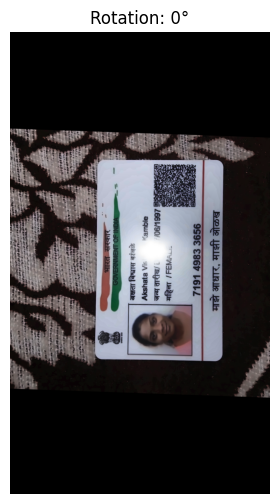

Face detected at 0 degrees rotation


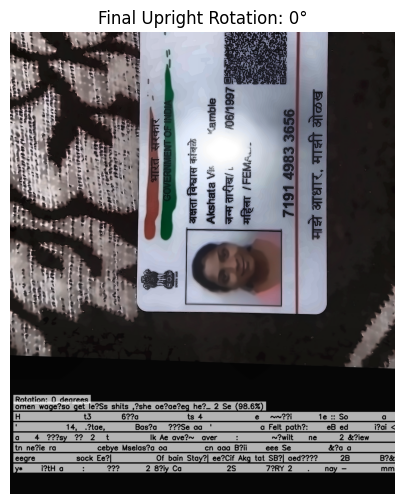

In [ ]:
import os
import cv2
import numpy as np
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import pytesseract
import matplotlib.pyplot as plt
from pathlib import Path

# Set Tesseract path (update this based on your installation)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Windows example

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define input directory
input_folder = Path("input")
input_folder.mkdir(exist_ok=True)

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to preprocess image for Faster R-CNN
def preprocess_image(image_path):
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = F.to_tensor(img_rgb).unsqueeze(0)  # Add batch dimension
    return img, img_rgb, img_tensor

# Function to enhance image dynamically
def enhance_image(image, denoise_h=10, clahe_clip=3.0):
    # Noise reduction with non-local means denoising
    denoised = cv2.fastNlMeansDenoisingColored(image, h=denoise_h, hColor=denoise_h, templateWindowSize=7, searchWindowSize=21)
    
    # Deblur using Gaussian blur and sharpening
    blurred = cv2.GaussianBlur(denoised, (5, 5), 0)
    sharpened = cv2.addWeighted(denoised, 1.5, blurred, -0.5, 0)
    
    # Contrast adjustment using CLAHE
    lab = cv2.cvtColor(sharpened, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(4, 4))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return enhanced

# Function to detect QR code position as a fallback
def detect_qr_code(image):
    qr_detector = cv2.QRCodeDetector()
    _, points = qr_detector.detect(image)
    if points is not None:
        points = points[0]
        centroid_x = int(np.mean(points[:, 0]))
        centroid_y = int(np.mean(points[:, 1]))
        return centroid_x, centroid_y
    return None, None

# Function to detect face and determine orientation
def detect_face_orientation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) > 0:
        return True, faces[0]  # Return True and the first detected face
    return False, None

# Function to correct skew and align the ID card to upright horizontal using face detection
def correct_skew(image):
    # Step 1: Detect the initial skew using Hough Lines
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    angle = 0
    if lines is not None:
        for rho, theta in lines[0]:
            angle = (theta * 180 / np.pi) - 90
            break

    # Step 2: Rotate the image based on the detected angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))

    # Step 3: Use face detection to determine the correct orientation
    orientations = [0, 90, 180, 270]
    correct_rotation = 0
    face_detected = False
    for rot_angle in orientations:
        temp_img = rotated.copy()
        if rot_angle == 90:
            temp_img = cv2.rotate(temp_img, cv2.ROTATE_90_CLOCKWISE)
        elif rot_angle == 180:
            temp_img = cv2.rotate(temp_img, cv2.ROTATE_180)
        elif rot_angle == 270:
            temp_img = cv2.rotate(temp_img, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Detect face in this orientation
        face_found, face = detect_face_orientation(temp_img)
        if face_found:
            print(f"Face detected at {rot_angle} degrees rotation")
            correct_rotation = rot_angle
            face_detected = True
            break

    # Step 4: Apply the correct rotation
    if face_detected:
        if correct_rotation == 90:
            rotated = cv2.rotate(rotated, cv2.ROTATE_90_CLOCKWISE)
        elif correct_rotation == 180:
            rotated = cv2.rotate(rotated, cv2.ROTATE_180)
        elif correct_rotation == 270:
            rotated = cv2.rotate(rotated, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        print("Face detection failed, falling back to Tesseract orientation detection")
        # Fallback to Tesseract orientation detection
        try:
            osd = pytesseract.image_to_osd(rotated, config='--psm 0')
            orientation = int(osd.split('Rotate: ')[1].split('\n')[0])
            print(f"Detected text orientation: {orientation} degrees")
            if orientation == 90:
                rotated = cv2.rotate(rotated, cv2.ROTATE_90_COUNTERCLOCKWISE)
                correct_rotation = 270  # Equivalent to rotating 90° counterclockwise
            elif orientation == 180:
                rotated = cv2.rotate(rotated, cv2.ROTATE_180)
                correct_rotation = 180
            elif orientation == 270:
                rotated = cv2.rotate(rotated, cv2.ROTATE_90_CLOCKWISE)
                correct_rotation = 90  # Equivalent to rotating 270° counterclockwise
        except:
            print("Tesseract orientation detection failed, falling back to QR code detection")
            # Fallback to QR code position
            qr_x, qr_y = detect_qr_code(rotated)
            if qr_x is not None and qr_y is not None:
                h, w = rotated.shape[:2]
                if qr_x < w // 2:  # QR code on the left, rotate 180 degrees
                    rotated = cv2.rotate(rotated, cv2.ROTATE_180)
                    correct_rotation = 180
                elif qr_y < h // 2:  # QR code at the top, rotate 90 degrees counterclockwise
                    rotated = cv2.rotate(rotated, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    correct_rotation = 270

    return rotated, correct_rotation

# Function to detect ROIs with Faster R-CNN
def detect_rois(model, img_tensor, threshold=0.1):  # Lowered threshold to detect more regions
    with torch.no_grad():
        predictions = model(img_tensor)[0]
    boxes = predictions['boxes'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    mask = scores > threshold
    # Filter boxes to focus on text-like regions
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []
    for box, score, label in zip(boxes[mask], scores[mask], labels[mask]):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        if width > 10 and height > 10 and width / height < 10:  # Reasonable text box constraints
            filtered_boxes.append(box)
            filtered_scores.append(score)
            filtered_labels.append(label)
    return np.array(filtered_boxes), np.array(filtered_scores), np.array(filtered_labels)

# Function to extract text from ROIs using OCR with improved preprocessing
def extract_text_from_roi(image, box):
    x1, y1, x2, y2 = map(int, box)
    roi = image[y1:y2, x1:x2]
    # Preprocess ROI for better OCR
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # Apply erosion to refine text boundaries
    kernel = np.ones((2, 2), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    # Use Tesseract with English and Hindi support
    text = pytesseract.image_to_string(thresh, lang='eng+hin', config='--psm 6 -c preserve_interword_spaces=1')
    return text.strip()

# Function to crop the ID card from the image
def crop_id_card(image, boxes):
    if len(boxes) == 0:
        return image
    largest_box = max(boxes, key=lambda b: (b[2] - b[0]) * (b[3] - b[1]))
    x1, y1, x2, y2 = map(int, largest_box)
    cropped = image[y1:y2, x1:x2]
    return cropped

# Function to find a suitable text placement region (e.g., bottom of the ID card)
def find_text_placement_region(image):
    h, w = image.shape[:2]
    # Assume bottom 20% of the image is a good spot for text (adjustable)
    return h - int(h * 0.2), h, 0, w

# Main processing function to display enhanced ID card with naturally integrated OCR text and rotation angle
def process_and_display_id_card(image_path):
    # Load and preprocess image
    original_img, img_rgb, img_tensor = preprocess_image(image_path)

    # Enhance and align the image
    enhanced_img = enhance_image(original_img)
    enhanced_img, rotation_angle = correct_skew(enhanced_img)

    # Detect ROIs
    _, enhanced_rgb, enhanced_tensor = preprocess_image(image_path)
    boxes, scores, labels = detect_rois(model, enhanced_tensor)

    # Extract text from ROIs
    ocr_results = []
    for i, box in enumerate(boxes[:10]):  # Increased to top 10 ROIs for better text detection
        text = extract_text_from_roi(enhanced_img, box)
        confidence = scores[i] * 100
        if text:
            ocr_results.append(f"{text} ({confidence:.1f}%)")

    # Crop the ID card
    cropped_id = crop_id_card(enhanced_img, boxes)
    cropped_id = enhance_image(cropped_id)  # Re-enhance for best quality

    # Find placement region for text (bottom of the ID card)
    y_start, y_end, x_start, x_end = find_text_placement_region(cropped_id)
    output_img = cropped_id.copy()

    # Overlay OCR text and rotation angle naturally on the ID card
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_thickness = 2
    text_color = (0, 0, 0)  # Black text for readability
    bg_color = (255, 255, 255, 50)  # Semi-transparent white background

    # Display rotation angle at the top of the text region
    rotation_text = f"Rotation: {rotation_angle} degrees"
    (text_w, text_h), baseline = cv2.getTextSize(rotation_text, font, font_scale, font_thickness)
    bg_x, bg_y = 10, y_start - text_h - 5
    bg_w, bg_h = text_w + 10, text_h + 10
    overlay = output_img.copy()
    cv2.rectangle(overlay, (bg_x, bg_y), (bg_x + bg_w, bg_y + bg_h), bg_color[:3], -1)
    cv2.addWeighted(overlay, 0.7, output_img, 0.3, 0, output_img)
    cv2.putText(output_img, rotation_text, (bg_x + 5, y_start), font, font_scale, text_color, font_thickness)

    # Display OCR results below the rotation angle
    y_offset = y_start + 20
    for result in ocr_results:
        # Calculate text size
        (text_w, text_h), baseline = cv2.getTextSize(result, font, font_scale, font_thickness)
        
        # Draw a semi-transparent background rectangle for contrast
        bg_x, bg_y = 10, y_offset - text_h - 5
        bg_w, bg_h = text_w + 10, text_h + 10
        overlay = output_img.copy()
        cv2.rectangle(overlay, (bg_x, bg_y), (bg_x + bg_w, bg_y + bg_h), bg_color[:3], -1)
        cv2.addWeighted(overlay, 0.7, output_img, 0.3, 0, output_img)
        
        # Add text
        cv2.putText(output_img, result, (bg_x + 5, y_offset), font, font_scale, text_color, font_thickness)
        y_offset += text_h + 15

        # Stop if we exceed the image height
        if y_offset + text_h > output_img.shape[0]:
            break

    # Display the result
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Enhanced ID Card with Natural OCR Text")
    plt.show()

# Process the first image in the input folder
image_files = list(input_folder.glob("*.jpg"))
if image_files:
    process_and_display_id_card(image_files[0])
else:
    print("No images found in the 'input' folder. Please add an ID card image (e.g., 'id_card.jpg').")